In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
from skimage import data
%matplotlib inline

In [2]:
!pip install scikit-image

You should consider upgrading via the 'pip install --upgrade pip' command.


## Histogram Equalization

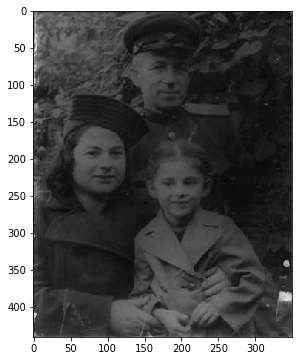

In [33]:
img = cv2.imread('images/war-time-1.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,6))
plt.imshow(img, cmap=cm.gray)
plt.show()

In [47]:
def get_hist_img(img):
    
    hist = np.zeros((256,), dtype=np.int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i,j]] += 1
            
    return hist

def histeq(img):
    
    hist = get_hist_img(img)
    hist_eq = np.zeros((256,), dtype=np.float64)
    eq_img = np.copy(img)
    MN = img.shape[0] * img.shape[1]
    for L,nk in enumerate(hist):
        prob = nk/MN
        if L == 0: 
            hist_eq[L] = L * prob
        else:
            hist_eq[L] = hist_eq[L-1] + L * prob
        indices = np.argwhere(eq_img == L)
        
        
        for i in indices:
            eq_img[i[0], i[1]] = round(hist_eq[L])
            
            
#     eq_img = ((eq_img - eq_img.min())/(eq_img.max() - eq_img.min())) * 255
#     eq_img = eq_img.astype(np.uint8)
    
    return get_hist_img(eq_img), eq_img, hist_eq.astype(int)

def local_histeq(img, kernel):
    M, N = img.shape
    x, y = kernel
    eq_img = np.copy(img)
    for i in range(0,M-x,x):
        for j in range(0,N-y,y):
            img_eq = np.copy(eq_img[i:i+x, j:j+y])
            
            _, eq_img[i:i+x, j:j+y], _ = histeq(img_eq)
    eq_img = scale_img(eq_img)      
    return eq_img

def hist_specify(img, ref_img):
    h_img, eq_img, lt_img = histeq(img)
    h_ref_img, eq_ref_img, lt_ref_img = histeq(ref_img)
    
    eq_spec_img = np.copy(eq_img)
    for L, eq_val_ref in zip(range(0,256), lt_ref_img):
        indices = np.argwhere(eq_spec_img == L)
        
        for i in indices:
            eq_spec_img[i[0], i[1]] = eq_val_ref
    
    eq_spec_img = ((eq_spec_img - eq_spec_img.min())/(eq_spec_img.max() - eq_spec_img.min())) * 255
    eq_spec_img = eq_spec_img.astype(np.uint8)
            
    return get_hist_img(eq_spec_img), eq_spec_img, h_ref_img

def apply_filter(img, kernel, kernel_type):
    M, N = img.shape
    x, y = kernel.shape
    e_img = np.copy(img)
    filtered_img = np.zeros((M,N))

    e_img = np.pad(e_img, [(0, x-1), (0, y-1)])

    
    if kernel_type == 'median':
        for i in range(M):
            for j in range(N):
                k_vals = e_img[i:i+x, j:j+y].flatten()
                med_val = np.median(k_vals)
                filtered_img[i,j] = med_val
                
    if kernel_type == 'mean':
        kernel = (1/np.sum(kernel))*kernel
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
                
    if kernel_type == 'filter':
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
    
    return scale_img(filtered_img)    

def plot_hist(hist):
    plt.figure(figsize=(8,6))
    plt.bar(list(range(0,256)), hist)
    plt.show()
    
def scale_img(img, qmin=0, qmax=255):
    max_val = img.max()
    min_val = img.min()
    scaled_img = ((img - min_val)/(max_val - min_val)) * (qmax - qmin)
    
    return scaled_img.astype(np.uint8)
    

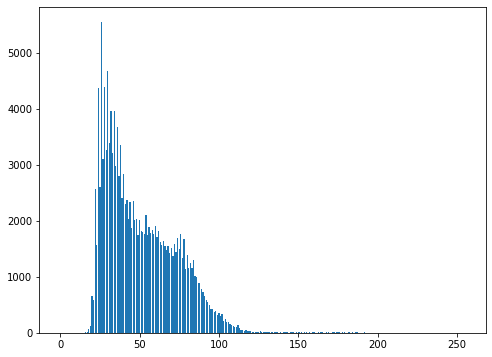

In [5]:
hist = get_hist_img(img)
plot_hist(hist)

256it [00:00, 936.89it/s]


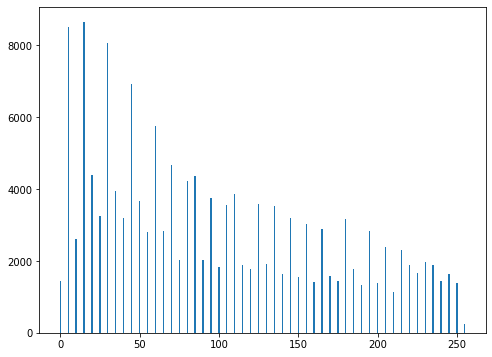

In [6]:
hist_eq, eq_img, lt = histeq(img)
plot_hist(hist_eq)

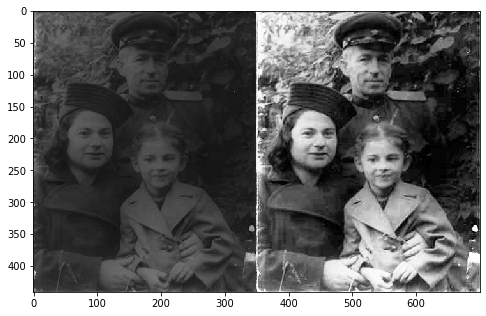

In [7]:
f_img = np.hstack((img, eq_img))
plt.figure(figsize=(8,6))
plt.imshow(f_img, cmap=cm.gray)

## Local Histogram Equalization

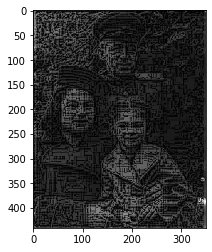

In [49]:
l_eq_img = local_histeq(img, (5,5))
plt.imshow(l_eq_img, cmap=cm.gray)

## Histomgram Specification

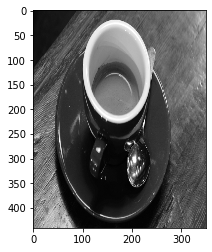

In [8]:
# ref_img = cv2.imread("images/cats-animals-grayscale-sleeping-1920x1080-48970.jpg", cv2.IMREAD_GRAYSCALE)
# ref_img = cv2.resize(ref_img, (img.shape[1], img.shape[0]))
# plt.figure(figsize=(8,6))
# plt.imshow(ref_img, cmap=cm.gray)

ref_img = data.coffee()
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
ref_img = cv2.resize(ref_img, (img.shape[1], img.shape[0]))
plt.imshow(ref_img, cmap=cm.gray)

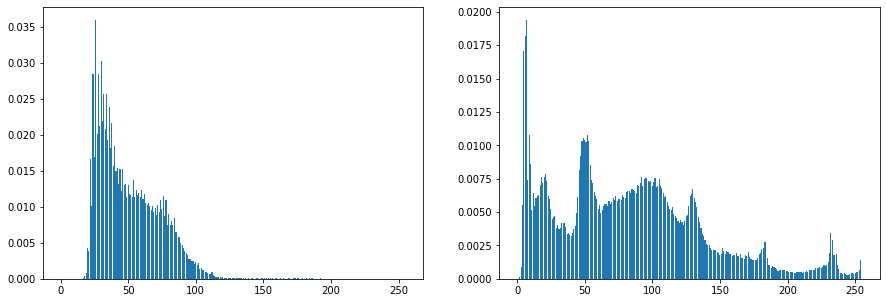

In [9]:
hist = get_hist_img(img)
ref_hist = get_hist_img(ref_img)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.bar(list(range(0,256)), hist/(img.shape[0]*img.shape[1]))
ax2.bar(list(range(0,256)), ref_hist/(ref_img.shape[0]*ref_img.shape[1]))
plt.show()

In [10]:
eq_spec_h, eq_spec_img, h_ref = hist_specify(img, ref_img)

256it [00:00, 920.79it/s]
256it [00:00, 910.39it/s]


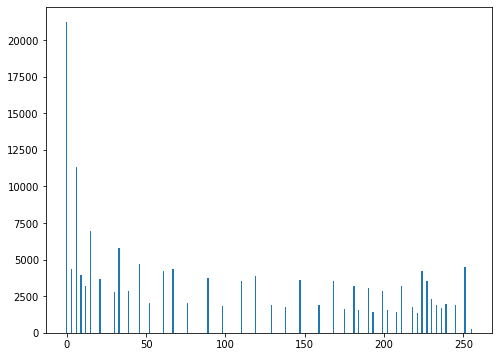

In [11]:
plot_hist(eq_spec_h)

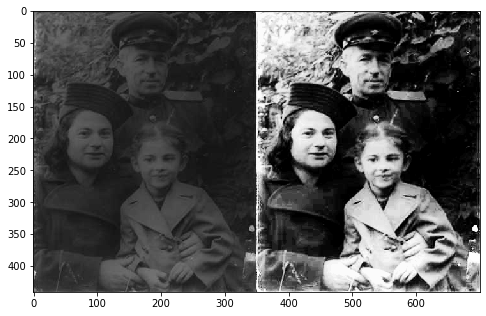

In [12]:
f_img = np.hstack((img, eq_spec_img))
plt.figure(figsize=(8,6))
plt.imshow(f_img, cmap=cm.gray)

## Mean and Median Filter

(201, 201)

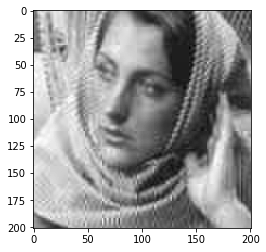

In [13]:
noisy_img = cv2.imread('images/jpeg91_055.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(noisy_img, cmap=cm.gray)
noisy_img.shape

100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


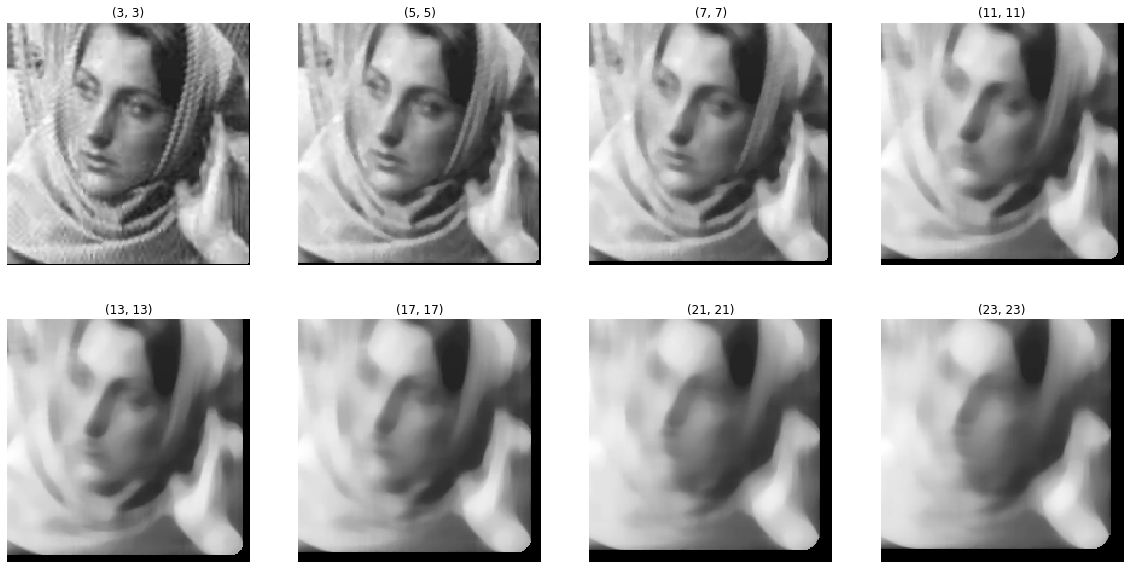

In [14]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.zeros(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'median'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


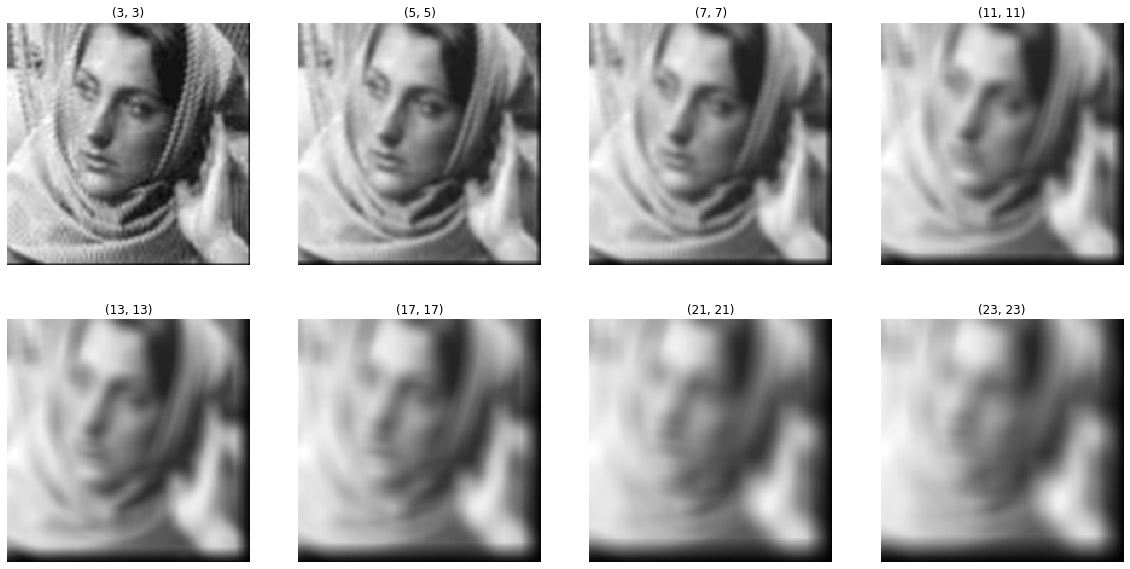

In [15]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.ones(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'mean'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

## High pass and High Boost Filters

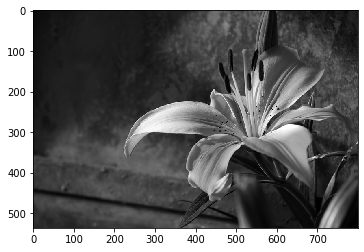

In [26]:
img = cv2.imread('images/390881995_81558d51cc_c.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=cm.gray)

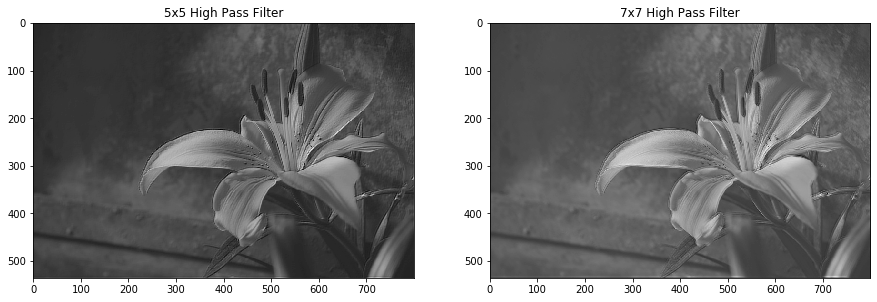

In [25]:
high_pass5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-2],
                      [-1,-4,22,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

high_pass7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-41,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

f_img5x5 = apply_filter(img, high_pass5x5_kernel, 'filter')
f_img7x7 = apply_filter(img, high_pass7x7_kernel, 'filter')

f_img5x5 = scale_img(np.add(img, -f_img5x5, dtype=np.float32))
f_img7x7 = scale_img(np.add(img, -f_img7x7, dtype=np.float32))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Pass Filter")
ax1.imshow(f_img5x5, cmap=cm.gray)

ax2.set_title("7x7 High Pass Filter")
ax2.imshow(f_img7x7, cmap=cm.gray)

In [28]:
high_pass5x5_kernel

array([[ 0, -1, -1, -1,  0],
       [-1,  2, -4,  2, -2],
       [-1, -4, 22, -4, -1],
       [-1,  2, -4,  2, -1],
       [ 0, -1, -1, -1,  0]])

In [29]:
high_pass7x7_kernel

array([[  1,   0,   0,   1,   0,   0,   1],
       [  0,   2,   0,   2,   0,   2,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   0,   0, -41,   0,   0,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   2,   0,   2,   0,   2,   0],
       [  1,   0,   0,   1,   0,   0,   1]])

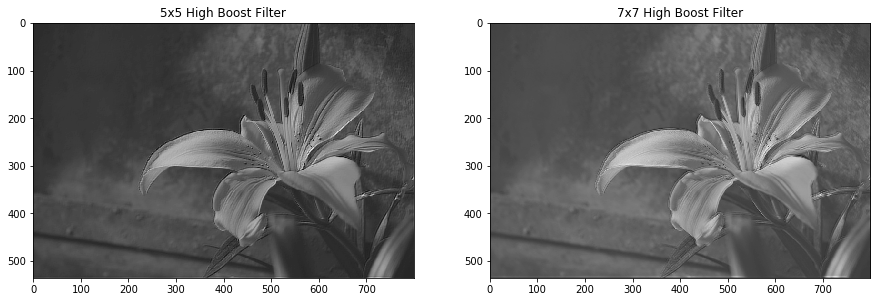

In [27]:
high_boost5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-2],
                      [-1,-4,23,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

high_boost7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-40,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

f_img5x5 = apply_filter(img, high_boost5x5_kernel, 'filter')
f_img7x7 = apply_filter(img, high_boost7x7_kernel, 'filter')

f_img5x5 = scale_img(np.add(img, -f_img5x5, dtype=np.float32))
f_img7x7 = scale_img(np.add(img, -f_img7x7, dtype=np.float32))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Boost Filter")
ax1.imshow(f_img5x5, cmap=cm.gray)

ax2.set_title("7x7 High Boost Filter")
ax2.imshow(f_img7x7, cmap=cm.gray)

In [30]:
high_boost5x5_kernel

array([[ 0, -1, -1, -1,  0],
       [-1,  2, -4,  2, -2],
       [-1, -4, 23, -4, -1],
       [-1,  2, -4,  2, -1],
       [ 0, -1, -1, -1,  0]])

In [31]:
high_boost7x7_kernel

array([[  1,   0,   0,   1,   0,   0,   1],
       [  0,   2,   0,   2,   0,   2,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   0,   0, -40,   0,   0,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   2,   0,   2,   0,   2,   0],
       [  1,   0,   0,   1,   0,   0,   1]])

## Sobel Operator

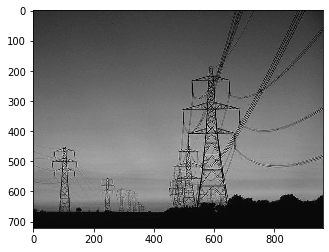

In [19]:
img = cv2.imread('images/image.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap=cm.gray)

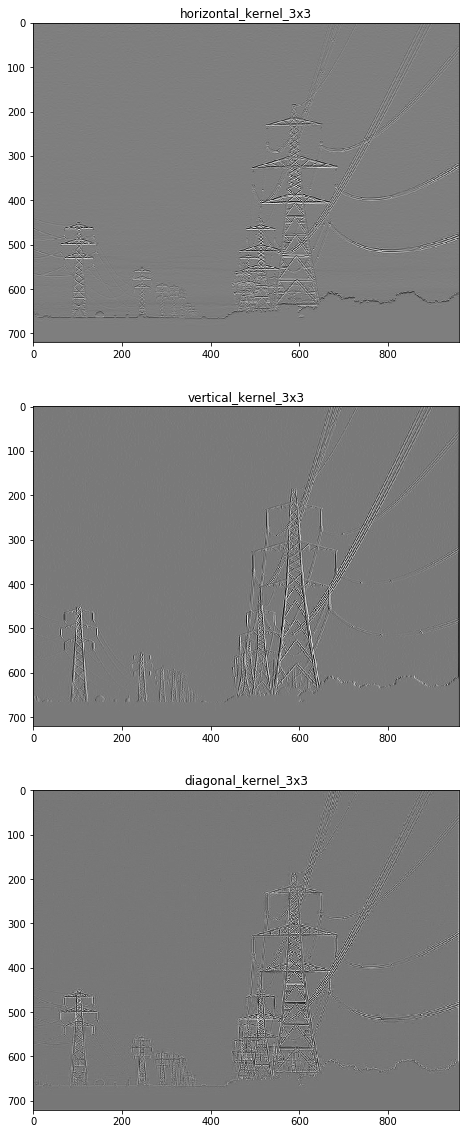

In [20]:
horizontal_kernel3x3 = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])
vertical_kernel3x3 = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])

diagonal_kernel3x3 = np.array([[-1,0,-1],
                     [0,4,0],
                     [-1,0,-1]])

f_img_h = apply_filter(img, horizontal_kernel3x3, 'filter')
f_img_v = apply_filter(img, vertical_kernel3x3, 'filter')
f_img_d = apply_filter(img, diagonal_kernel3x3, 'filter')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,20))

ax1.set_title("horizontal_kernel_3x3")
ax1.imshow(f_img_h, cmap=cm.gray)

ax2.set_title("vertical_kernel_3x3")
ax2.imshow(f_img_v, cmap=cm.gray)

ax3.set_title("diagonal_kernel_3x3")
ax3.imshow(f_img_d, cmap=cm.gray)

## Automatic Mask Creation

(373, 320)

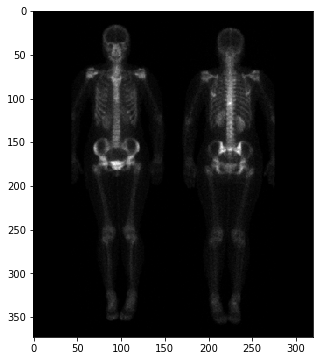

In [21]:
img = cv2.imread('images/a.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,6))
plt.imshow(img, cmap=cm.gray_r)
img.shape

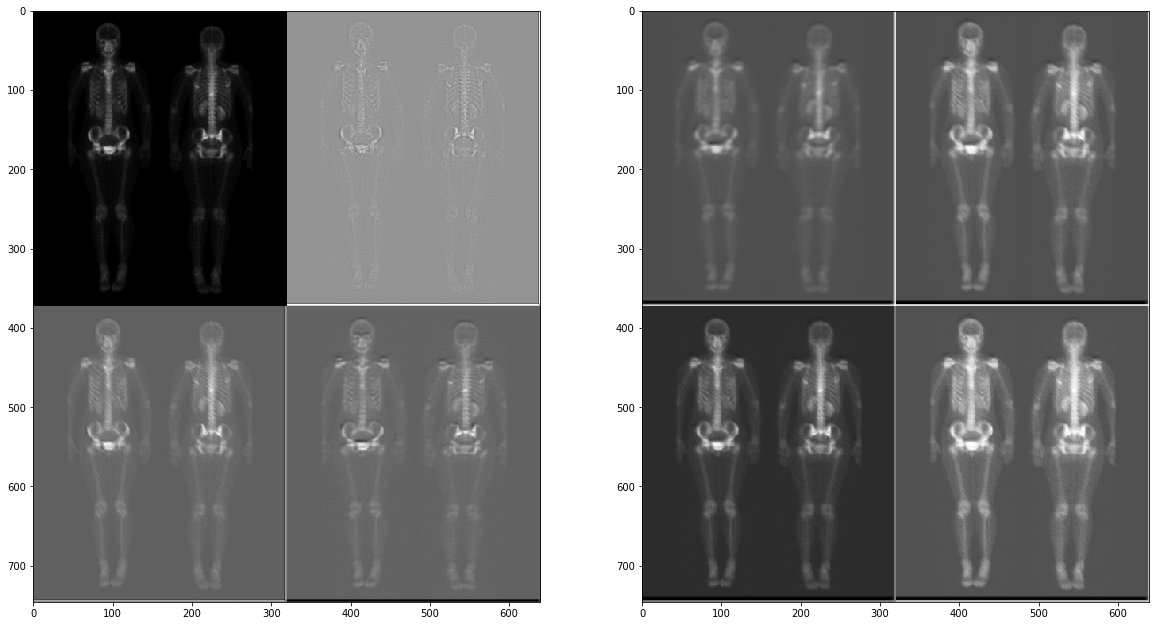

In [22]:
img_b = apply_filter(img, high_boost5x5_kernel, 'filter')
sobel_operator = np.array([[2,2,4,2,2],
                 [1,1,2,1,1],
                 [0,0,0,0,0],
                 [-1,-1,-2,-1,-1],
                 [-2,-2,-4,-2,-2]])

img_c = scale_img(np.add(img, img_b, dtype=np.float32))

img_d = apply_filter(img, sobel_operator, 'filter')
img_d = scale_img(np.add(img, img_d, dtype=np.float32))

avg_kernel = np.ones((5,5))
img_e = apply_filter(img_d, avg_kernel, 'mean')

img_f = scale_img(np.multiply(img_c, img_e, dtype=np.int64))

img_g = scale_img(np.add(img, img_f, dtype=np.float32))

img_h = np.array(255*(img_g/255)**2,dtype='uint8')

imgs_a_d = np.vstack((np.hstack((img, img_b)), np.hstack((img_c, img_d))))
                     
imgs_e_g = np.vstack((np.hstack((img_e, img_f)), np.hstack((img_g, img_h))))
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,20))

ax1.imshow(imgs_a_d, cmap=cm.gray_r)
ax2.imshow(imgs_e_g, cmap=cm.gray_r)